In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



import statsmodels.api as sm


gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1., allow_growth=True)
   
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)  

In [2]:
os.chdir('/home/nnlinux/Documentos/git-repos/doutorado/phD-thesis-project/')

       Agropecuária  Indústria  Infraestrutura  Comércio e serviços  \
count     72.000000  72.000000       72.000000            72.000000   
mean       0.135622   0.565348        0.495093             0.219978   
std        0.065522   0.458333        0.270936             0.153548   
min        0.053407   0.028426        0.085215             0.022447   
25%        0.091239   0.265550        0.274034             0.104358   
50%        0.118062   0.540207        0.491297             0.175733   
75%        0.149423   0.709280        0.658696             0.336986   
max        0.370092   2.638441        1.143117             0.832406   

           Total  Investimento  
count  72.000000     72.000000  
mean    1.416042     17.987601  
std     0.779904      2.096092  
min     0.202680     14.268541  
25%     0.939751     16.376876  
50%     1.439447     17.847753  
75%     1.773297     20.039805  
max     3.913393     21.525857  


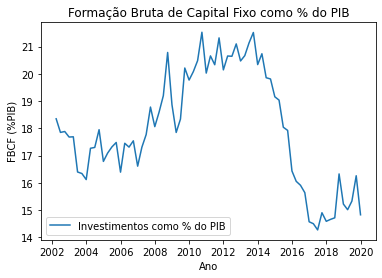

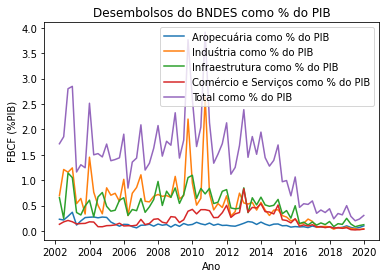

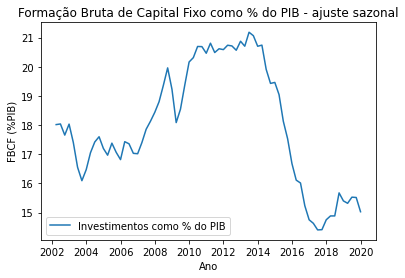

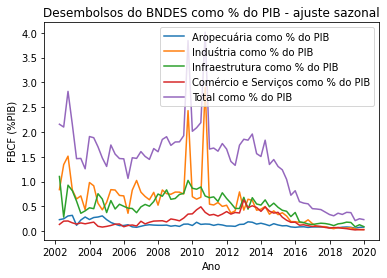

,Inv,Agr,Ind,Inf,Com
date,,,,,
2002-03-31,18.017116,0.231266,0.836440,1.101536,0.135042
2002-04-30,18.024239,0.237004,1.004470,0.828353,0.157193
2002-05-31,18.031363,0.242741,1.172500,0.555169,0.179344
2002-06-30,18.038487,0.248479,1.340529,0.281986,0.201495
2002-07-31,17.911289,0.267514,1.397601,0.496783,0.202467


In [3]:
### READ DATA ###

# Carrega os dados
github_repo = 'https://raw.githubusercontent.com/carlosvneves/doutorado/master/'
desembolsos = pd.read_csv(github_repo + 'desembolsos.csv')
pib = pd.read_csv(github_repo +'pib.csv')
fbcf = pd.read_csv(github_repo +'fbcf.csv') 

fbcf.index = pd.to_datetime(fbcf['date'])
fbcf.drop(['date'],inplace=True, axis = 1)

    
pib.index = pd.to_datetime(pib['date'])
pib.drop(['date'],inplace=True, axis = 1)


desembolsos.index = pd.to_datetime(desembolsos['date'])
desembolsos.drop(['date'], inplace=True, axis = 1)
    
data = desembolsos.groupby(pd.PeriodIndex(desembolsos.index, freq='Q')).mean()
data = data.loc['1996Q1':]
data.index = data.index.to_timestamp(freq='Q')

for col in data.columns:
    data[col] = data[col]/pib['pib'].values * 100
    
    
# Corte da série de acordo com a análise de tendência
start = '2002Q1'

data['Investimento'] = fbcf['fbcf'].values/pib['pib'].values *100
data = data.loc[start:]

print(data.describe())


# Visualiza os dados originais
plt.figure()
plt.plot(data.index,data[['Investimento']],
          label = 'Investimentos como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
plt.title('Formação Bruta de Capital Fixo como % do PIB')
#plt.savefig('investimentos')
plt.show()

plt.figure()
plt.plot(data.index,data[['Agropecuária']],
          label = 'Aropecuária como % do PIB')
plt.plot(data.index,data[['Indústria']],
          label = 'Induśtria como % do PIB')
plt.plot(data.index,data[['Infraestrutura']],
          label = 'Infraestrutura como % do PIB')
plt.plot(data.index,data[['Comércio e serviços']],
          label = 'Comércio e Serviços como % do PIB')
plt.plot(data.index,data[['Total']],
          label = 'Total como % do PIB')
plt.title('Desembolsos do BNDES como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
#plt.savefig('desembolsos')
plt.show()
  


data[['Agropecuária','Indústria','Infraestrutura','Comércio e serviços', 'Total']]


# Ajuste Sazonal (X-13 ARIMA) das séries para otimizar a modelagem
X13_PATH = os.path.join('x13/')

data_sa = pd.DataFrame(data)
data_sa.rename(columns=lambda x: x[0:3], inplace=True)

for col in data_sa:
  sa = sm.tsa.x13_arima_analysis(data_sa[col],x12path=X13_PATH)
  data_sa[col] = sa.seasadj.values

data_sa.tail()


# Visualiza dados com ajuste sazonal 

plt.figure()
plt.plot(data_sa.index,data_sa[['Inv']],
        label = 'Investimentos como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
plt.title('Formação Bruta de Capital Fixo como % do PIB - ajuste sazonal')
#plt.savefig('investimentos-sa')
plt.show()

plt.figure()
plt.plot(data_sa.index,data_sa[['Agr']],
        label = 'Aropecuária como % do PIB')
plt.plot(data_sa.index,data_sa[['Ind']],
        label = 'Induśtria como % do PIB')
plt.plot(data_sa.index,data_sa[['Inf']],
        label = 'Infraestrutura como % do PIB')
plt.plot(data_sa.index,data_sa[['Com']],
        label = 'Comércio e Serviços como % do PIB')
plt.plot(data_sa.index,data_sa[['Tot']],
        label = 'Total como % do PIB')
plt.title('Desembolsos do BNDES como % do PIB - ajuste sazonal')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
#plt.savefig('desembolsos-sa')
plt.show() 
#  Unsample dos dados de Trim para Mensal
upsampled = data_sa.resample('M')
interpolated = upsampled.interpolate(method='linear')
interpolated.tail(24)

data = interpolated
data = data[['Inv','Agr','Ind','Inf','Com']]
data.head() 

In [14]:
series = pd.DataFrame(data['Inv'])

split = 0.7

train_date = series.index[:int(len(series)*split)]
train = series[:int(len(series)*split)].copy()
        
test_date = series.index[int(len(series)*split):]
test = series[int(len(series)*split):].copy()

In [63]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

ndiffs = ndiffs(series['Inv'], test = 'adf')

print(ndiffs)

train_diff = train.diff(ndiffs).dropna()
series_diff= series.diff(ndiffs).dropna()

arima_model =  pm.auto_arima(series_diff, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

1
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=-302.746, BIC=-286.254, Time=0.696 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=-199.813, BIC=-193.217, Time=0.024 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=-233.490, BIC=-220.296, Time=0.216 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=-304.758, BIC=-291.565, Time=0.625 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=-201.802, BIC=-198.504, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=-195.813, BIC=-182.620, Time=0.056 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=-300.914, BIC=-281.124, Time=1.043 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit 

In [64]:
date = train_date[-1]
forward = len(test)
date_range = pd.date_range(date, periods=forward+1, freq='M', closed='right')
 
print(arima_model.fit(train_diff))    
    
    
final_pred = arima_model.predict(forward)
final_true = series_diff.loc[date_range]

ARIMA(order=(0, 1, 0), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)


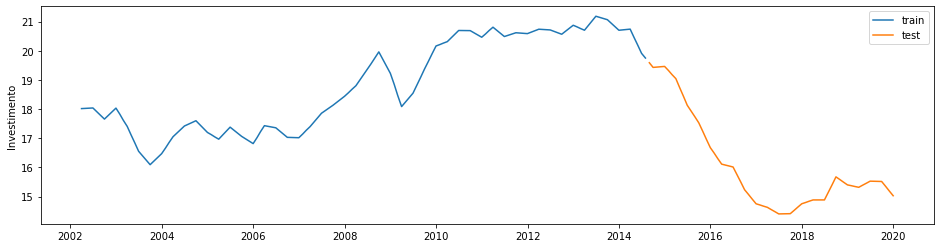

In [65]:
plt.figure(figsize=(16,4))
plt.plot(train_date, train, label='train')
plt.plot(test_date, test, label='test')
plt.ylabel('Investimento'); plt.legend()
plt.show()

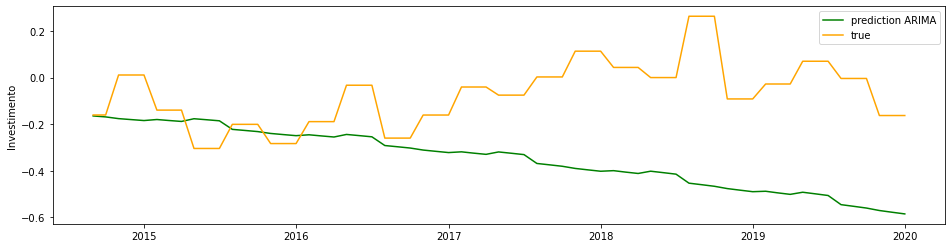

In [66]:
plt.figure(figsize=(16,4))
plt.plot(date_range, final_pred, c='green', label='prediction ARIMA')
plt.plot(date_range, final_true.values, c='orange', label='true')
plt.ylabel('Investimento'); plt.legend()
plt.show()
    

In [67]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [68]:
pred_df = pd.DataFrame(final_pred, index = test_date, columns=['Inv_1d'])

pred_undiff = invert_transformation(train,pred_df)

pred_undiff.head()


,Inv_1d,Inv_forecast
date,,
2014-08-31,-0.164714,19.586521
2014-09-30,-0.168842,19.417679
2014-10-31,-0.176220,19.241458
2014-11-30,-0.180348,19.061110
2014-12-31,-0.184476,18.876634


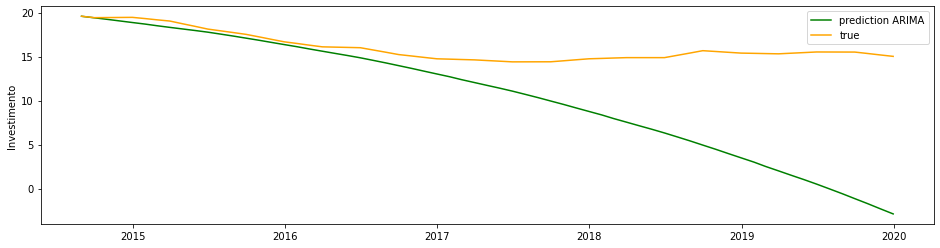

In [69]:
plt.figure(figsize=(16,4))
plt.plot(date_range, pred_undiff['Inv_forecast'].values, c='green', label='prediction ARIMA')
plt.plot(date_range, test.values, c='orange', label='true')
plt.ylabel('Investimento'); plt.legend()
plt.show()
    

In [70]:
print(arima_model.order)

(0, 1, 0)


In [83]:
train.shape

(149, 1)

                             ARIMA Model Results                              
Dep. Variable:                  D.Inv   No. Observations:                  212
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 189.598
Method:                           css   S.D. of innovations              0.099
Date:                Sat, 11 Jul 2020   AIC                           -375.196
Time:                        18:06:45   BIC                           -368.483
Sample:                    05-31-2002   HQIC                          -372.483
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.007     -0.118      0.906      -0.014       0.013


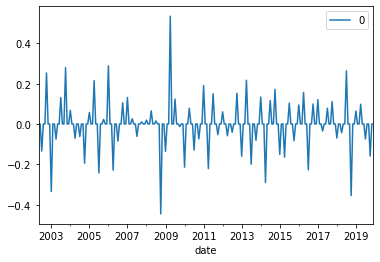

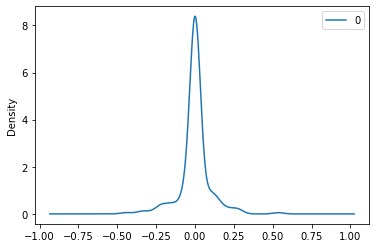

                  0
count  2.120000e+02
mean  -2.897888e-17
std    9.917143e-02
min   -4.449315e-01
25%    8.020078e-04
50%    8.020078e-04
75%    8.020078e-04
max    5.346183e-01


In [85]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# fit model
model = ARIMA(series_diff, order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [86]:
model_fit.forecast()

(array([-0.16370398]),
 array([0.09893726]),
 array([[-0.35761744,  0.03020949]]))

predicted=-0.161719, expected=-0.160586
predicted=-0.161712, expected=0.011174
predicted=0.011201, expected=0.011174
predicted=0.011200, expected=0.011174
predicted=0.011200, expected=-0.139663
predicted=-0.140622, expected=-0.139663
predicted=-0.140616, expected=-0.139663
predicted=-0.140610, expected=-0.304398
predicted=-0.306395, expected=-0.304398
predicted=-0.306382, expected=-0.304398
predicted=-0.306370, expected=-0.200792
predicted=-0.202099, expected=-0.200792
predicted=-0.202091, expected=-0.200792
predicted=-0.202083, expected=-0.283355
predicted=-0.285149, expected=-0.283355
predicted=-0.285138, expected=-0.283355
predicted=-0.285127, expected=-0.189120
predicted=-0.190309, expected=-0.189120
predicted=-0.190302, expected=-0.189120
predicted=-0.190295, expected=-0.032773
predicted=-0.033010, expected=-0.032773
predicted=-0.033009, expected=-0.032773
predicted=-0.033007, expected=-0.259876
predicted=-0.261437, expected=-0.259876
predicted=-0.261428, expected=-0.259876
predic

/home/nnlinux/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nnlinux/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nnlinux/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.043837, expected=0.000121
predicted=0.000084, expected=0.000121
predicted=0.000084, expected=0.000121
predicted=0.000085, expected=0.263515
predicted=0.264830, expected=0.263515
predicted=0.264824, expected=0.263515
predicted=0.264817, expected=-0.091671
predicted=-0.092170, expected=-0.091671
predicted=-0.092168, expected=-0.091671
predicted=-0.092165, expected=-0.027517
predicted=-0.027689, expected=-0.027517
predicted=-0.027689, expected=-0.027517
predicted=-0.027688, expected=0.070234
predicted=0.070544, expected=0.070234
predicted=0.070542, expected=0.070234
predicted=0.070541, expected=-0.003731
predicted=-0.003783, expected=-0.003731
predicted=-0.003783, expected=-0.003731
predicted=-0.003783, expected=-0.162902
predicted=-0.163712, expected=-0.162902
predicted=-0.163708, expected=-0.162902
Test MSE: 0.007


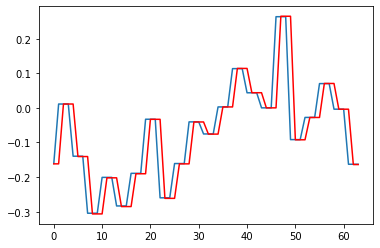

In [82]:
# Rolling ARIMA
X = series_diff.values
size = int(len(X) * split)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [84]:
len(predictions)

64